In [1]:
#!pip install ../ --upgrade

In [54]:
import numpy as np
from Pythogen import cells, model, signals
from Pythogen.nx import extract_graph_info, attr_to_arr

meanCellRadius, meanPDRadius = 25, 5e-3

cell_params = cells.Cells(meanCellRadius, meanPDRadius, cellSizeGradientPC=0)

defSignal = signals.Signal(300, 0, 'defenceSignal')


def init_func(signal, G, names):
    idx = np.random.randint(G.number_of_nodes())
    G.nodes(data=True)[idx]['defenceSignal'] = 1


defSignal.add_onAdd_function(init_func)

mdl = model.Model('hexagon')
mdl.add_cell_features(cell_params)
mdl.add_signal(defSignal)


df = mdl.to_pd()
df.sort_values(by='defenceSignal', ascending=False).head()


def transport(dx, C,A):
    total_outs = np.zeros(C.shape)
    total_ins = np.zeros(C.shape)
    for c in range(len(C)):
        conns = np.where(A[c] == 1)[0]
        outs = dx[conns] # connections deff to us
        out_deff = np.ones(conns.shape) * dx[c]
        out_deff[out_deff > outs] = outs[outs < out_deff]
        tout = out_deff*4*C[c]
        total_ins[conns] += tout 
        total_outs[c] = np.sum(tout)
    return C+total_ins-total_outs

def f_out(dx, C):

    #d is calculated per cell currently... 

    return dx*(4*C) # total loss!

def f_in(dx, C, A):
    n_c = np.zeros(C.shape)
    for c in range(len(C)):
        conns = np.where(A[c] == 1)
        n_c[c] = np.sum(C[conns])
    return n_c

name = "defenceSignal"
G = mdl.G
dt=1
D=100
E, C = extract_graph_info(G, kind=name)
nn = np.sum(E, axis=1) #num neighbours of each cell list
dx = attr_to_arr(G, 'radius')
dx = ((D*dt)/dx**2) / nn 
# let's assume ALWAYS even share for all neighbours of cell-wall

eo = f_out(dx, C) # total leaving each cell
pn_loss = eo / np.sum(E, axis=0) # loss divided equally
ein = f_in(dx, pn_loss, E)
np.sum(C)

1.0

In [55]:
name = "defenceSignal"
G = mdl.G
dt=1
D=100
E, C = extract_graph_info(G, kind=name)
nn = np.sum(E, axis=1) #num neighbours of each cell list
dx = attr_to_arr(G, 'radius')
dx = ((D*dt)/dx**2) / nn 
# let's assume ALWAYS even share for all neighbours of cell-wall
np.sum(transport(dx,C,E))

1.0

In [51]:
A = E
total_outs = np.zeros(C.shape)
total_ins = np.zeros(C.shape)
for c in range(len(C)):
    conns = np.where(A[c] == 1)[0]
    outs = dx[conns] # connections deff to us
    out_deff = np.ones(conns.shape) * dx[c]
    out_deff[out_deff > outs] = outs[outs < out_deff]
    tout = out_deff*4*C[c]
    total_ins[conns] += tout 
    total_outs[c] = np.sum(tout)
    break

In [50]:
out_deff

array([0.08, 0.08])

In [6]:

from Pythogen.nx import extract_graph_info, attr_to_arr
name = "defenceSignal"
G = mdl.G
dx = attr_to_arr(G, 'radius')
E, C = extract_graph_info(G, kind=name)
dx2 = dx**2
q_hat = np.zeros( (2, len(E), len(E)) )
D = defSignal.Deff
dt = 1
q_hat[0] = (D* dt *E) # Potential per connection! 
q_hat[1] = (E.T * dt * D).T
q_hat = np.min(q_hat, axis=0)
diag_C = np.diag(C)
epochs = 1
for _ in range(epochs):
    E_hat = (diag_C/dx2) * q_hat
    diag_C = diag_C + (np.sum(E_hat, axis=1)-np.sum(E_hat, axis=0))

# Does 1D Pythogen Model match 1D Eq

In [51]:
import numpy as np
from Pythogen import cells, model, signals

meanCellRadius, meanPDRadius = 10, 5e-3

cell_params = cells.Cells(meanCellRadius, meanPDRadius)

defSignal = signals.Signal(300, 0, 'defenceSignal')


def init_func(signal, G, names):
    idx = 55
    G.nodes(data=True)[idx]['defenceSignal'] = 1


defSignal.add_onAdd_function(init_func)

mdl = model.Model("rectangle", NCellsY=1, NCellsX = 110 )
mdl.add_cell_features(cell_params)
mdl.add_signal(defSignal)

mdl.run(60, dt=1/10)

df = mdl.to_pd()
df.sort_values(by='defenceSignal', ascending=False).head()


,x,y,neighbours,num_neighbours,distCentre,radius,radius_ep_original,radius_ep,num_pd,defenceSignal,Deff,shape
55,0,55,"[54, 56]",2,0,10.0,0.005,0.005,1000.0,0.075686,23.334862,rectangle
54,0,54,"[53, 55]",2,1,10.0,0.005,0.005,1000.0,0.074325,23.334862,rectangle
56,0,56,"[55, 57]",2,1,10.0,0.005,0.005,1000.0,0.074325,23.334862,rectangle
57,0,57,"[56, 58]",2,2,10.0,0.005,0.005,1000.0,0.07039,23.334862,rectangle
53,0,53,"[52, 54]",2,2,10.0,0.005,0.005,1000.0,0.07039,23.334862,rectangle


## Just remember to divide C of Pythogen by dimension of cell (L in 1D, A in 2D)

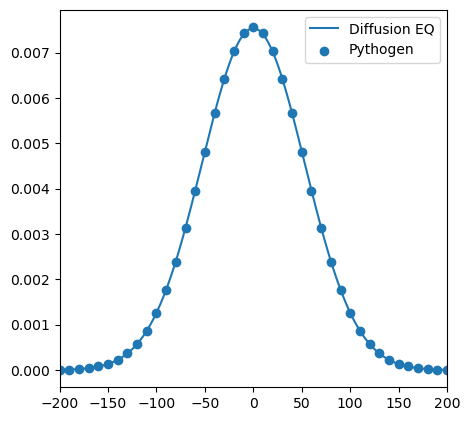

In [52]:
import matplotlib.pyplot as plt 

D = np.mean(df['Deff'])

x = np.linspace(-55*meanCellRadius/2, 55*meanCellRadius/2, 1000)

def diffeq(x,t,D):
    return (1/(np.sqrt(4*np.pi*D*t)))*np.exp(-((x**2)/(4*D*t) ))

fig, ax = plt.subplots(1, figsize=(5,5), dpi=100)
ax.plot(x, diffeq(x,60,D), label="Diffusion EQ")
#tdf = df[df["y"]>50 & df["y"] < 60]
ax.scatter((df['y']*meanCellRadius)-meanCellRadius*55, df['defenceSignal']/meanCellRadius, label="Pythogen")
ax.set_xlim(-200,200)
ax.legend()


